In [74]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
words = open('names.txt', 'r').read().splitlines()

In [76]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [77]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [78]:
# MLP
n_embd = 10 # dimensionality of embedding vectors
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(32435435)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [79]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3091
  10000/ 200000: 2.2582
  20000/ 200000: 2.0132
  30000/ 200000: 2.4485
  40000/ 200000: 2.0441
  50000/ 200000: 2.1606
  60000/ 200000: 2.1613
  70000/ 200000: 2.0928
  80000/ 200000: 2.3407
  90000/ 200000: 2.1381
 100000/ 200000: 2.0801
 110000/ 200000: 1.8554
 120000/ 200000: 2.1245
 130000/ 200000: 2.0105
 140000/ 200000: 1.9693
 150000/ 200000: 2.3687
 160000/ 200000: 2.1649
 170000/ 200000: 2.2682
 180000/ 200000: 2.1302
 190000/ 200000: 1.7751


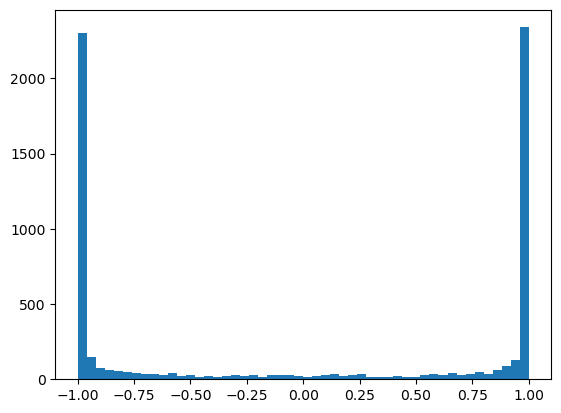

In [80]:
plt.hist(h.view(-1).tolist(), 50); # adding ; only outputs the histogram (suppresses other output)
# we view h (the tanh activation layer values) with a shape (32, 200) as a one large array of size 6400
# the plot shows that most of the values fall on the boundaries, and that makes sense because of the tanh curve

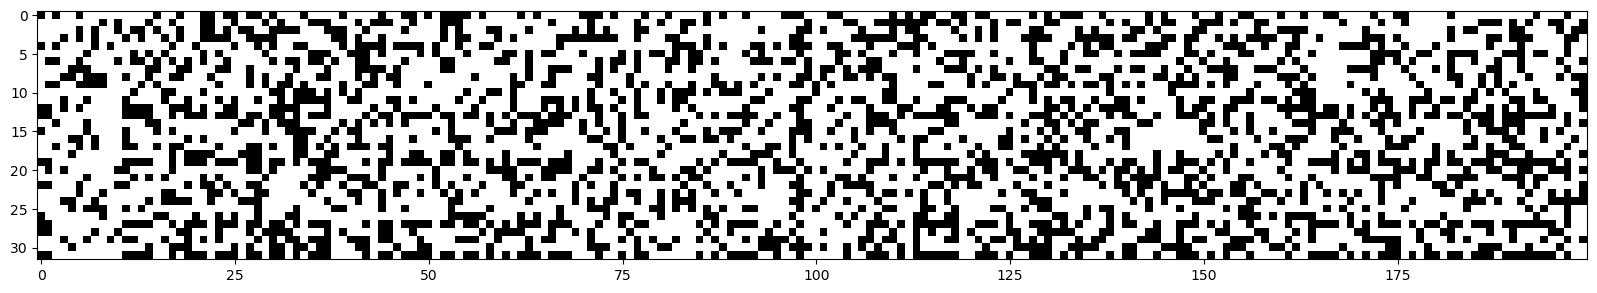

In [81]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# boolean tensor - white if true, black if false
# most of the cells look white, so they are at the flat tail of the graph

It would be a problem if we had a whole white column because it will mean that the neuron will not learn, it's fully in the flat tail. The gradient in that region is 0 (remember how we initialized tanh function: self.grad += (1-t^2) * out.grad

When $t = \pm 1$, there is no contribution from neurons in that flat-tail region. 

In [82]:
# Now if I multiply W1 and b1 by 0.1 and 0.01:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(32435435)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5) # precise scaling factor given by gain/√fan_in
# gain is 5/3 for tanh functions, and fan in is n_embd * block_size, therefore we scale by approx 0.3
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [83]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # uncomment the following line to run the first batch only
    # break

      0/ 200000: 3.3235
  10000/ 200000: 2.1825
  20000/ 200000: 2.0288
  30000/ 200000: 2.3004
  40000/ 200000: 1.8846
  50000/ 200000: 2.1878
  60000/ 200000: 2.0864
  70000/ 200000: 1.9859
  80000/ 200000: 2.2402
  90000/ 200000: 2.0469
 100000/ 200000: 2.1133
 110000/ 200000: 1.8787
 120000/ 200000: 2.0813
 130000/ 200000: 1.9500
 140000/ 200000: 1.9835
 150000/ 200000: 2.2471
 160000/ 200000: 2.1897
 170000/ 200000: 2.2634
 180000/ 200000: 2.0884
 190000/ 200000: 1.7507


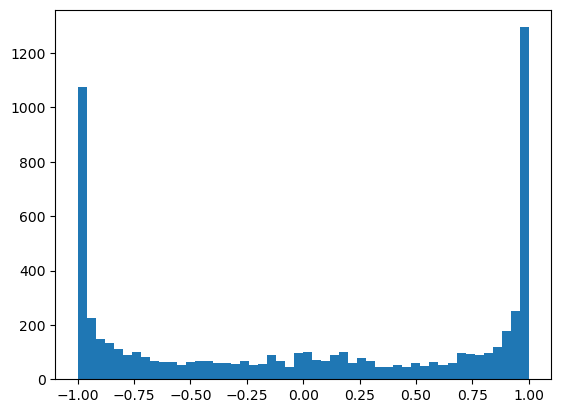

In [84]:
plt.hist(h.view(-1).tolist(), 50);
# much better historgram and smaller amount of saturated neurons

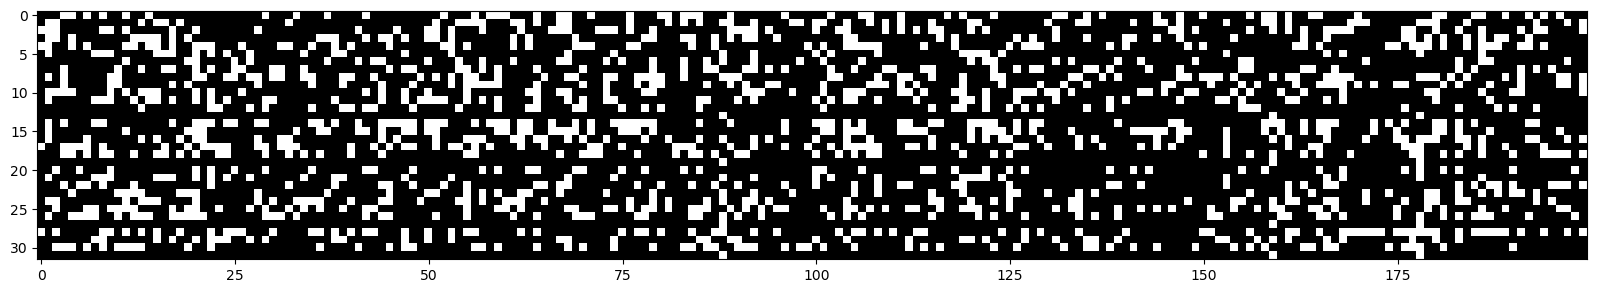

In [85]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# small amount of saturated neurons

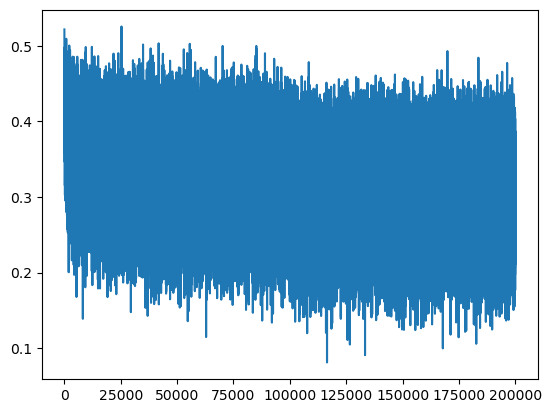

In [86]:
plt.plot(lossi)

In [87]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0417444705963135
val 2.1045382022857666


## Batch normalization

In [104]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(32435435)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # this is redundant, no bias in the linear layer, bias in the BN layer is enough
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) # 0s because for standard Gaussian, mean is roughly 0
bnstd_running = torch.ones((1, n_hidden)) # 1s because for standard Gaussian, std is roughly 1

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [105]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer preactivation
    # standardize the values and introduce batch normalization bias and gain (scale and shift)
    # thus, no matter what the incoming distribution is, the outcome is the unit gaussian
    # BatchNorm layer
    # ----------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True) # mean and std of the activations
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # here we center to be unit Gaussian
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # uncomment the following line to run the first batch only
    # break

      0/ 200000: 3.2902
  10000/ 200000: 2.3062
  20000/ 200000: 2.3043
  30000/ 200000: 1.9235
  40000/ 200000: 2.0072
  50000/ 200000: 2.0376
  60000/ 200000: 2.1073
  70000/ 200000: 2.4046
  80000/ 200000: 1.8984
  90000/ 200000: 2.4358
 100000/ 200000: 2.2582
 110000/ 200000: 2.3682
 120000/ 200000: 1.9338
 130000/ 200000: 2.1273
 140000/ 200000: 1.8957
 150000/ 200000: 2.3212
 160000/ 200000: 2.2311
 170000/ 200000: 1.8191
 180000/ 200000: 2.2918
 190000/ 200000: 2.0065


In [106]:
# calibrate batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True) # these are fixed numbers

In [107]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias 
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.072145462036133
val 2.1127707958221436


**Summary of batch normalization:**

Batch normalization is a layer that we can "sprinkle throughout" the neural net. We want roughly Gaussian activations, and we take the mean and standard deviation of the activations to center the data. It is possible to center because the centering operation is differentiable.

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(31435267)

for _ in range(20):
    out = []
    context = [0] * block_size 
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item() # sample from the distribution
        context = context[1:] + [idx] # shift the context window
        out.append(idx)
        if idx == 0:
            break
    print(''.join(itos[i] for i in out))